# Notebook assigment

# Motivation


* What is your dataset?

* Why did you choose this/these particular dataset(s)?

* What was your goal for the end user’s experience?

Our data resolves around music. We have four different types of data sets. 

________

The first, is a ranked list of songs (with the artist of the song) which have been spending the most time on the spotify U.S. charts counting in the period 2013-2023, https://kworb.net/spotify/country/us_weekly_totals.html. The list is ranking 7653 different songs. This data set is used to get a list of artist primarily singing in the English language. By taking the set of these, 1250 unique artist from the top charts are left, who all at least has had one major song. This ensures that at least some lyrics of these artists are able to be found. We hope to generalize some of the findings on this sample of artists, however, the use of these artists will be discussed later. 

Also, data is collected from the spotify-API, https://developer.spotify.com/documentation/web-api. Here, the genres of the artist are collected as well as the features of that artist. The features enables us to make connections between artists, and by using the genres of the artist a broader analysis can be made.
Finally, the lyrics from the three most popular songs of each artist are collected in order to do text analysis, collected from Genius, https://docs.genius.com.

The main research questions for the project are: 

1. Artists under which genres have the most collaborations?
2. Are collaborations most likely to happen between artists within the same genre and which collaborations are most likely to happen between artists in the largest genres?
3. Which differences in the genres can be found, specifically when looking at the language?



# Basic stats. Let’s understand the dataset better


* Write about your choices in data cleaning and preprocessing
    

* Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

_________

A number of assumptions are done to get to the final data set, which is used to form the network and make basic descriptive stats. The most important preprocessing involves getting the top-genre for each artist, since spotify can associate multi genres per artist. This will be elaborated after the loading of the data.



## _Get dependencies_

In [25]:
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import nltk
import re
import json
import base64
import itertools
from tqdm.auto import tqdm
import pickle
import networkx as nx
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain
import netwulf as nw
import warnings
from IPython.display import Image
warnings.filterwarnings("ignore")

## _Load data_

### 1. Top charts artist
Loading of the ranked top charts and the artist of the songs into a dataframe - we take the set of artists:

In [62]:
df_charts_artist = pd.read_csv('artists_charts.csv')
unique_artists = df_charts_artist['artist'].unique()

### 2. and 3. Features and Genres

We read the spotify features and genres for each artist into two dictionaries:

In [63]:
def read_files(preprocess=False):
    if not input:
        with open('dict_featuresALL.pickle', 'rb') as handle:
            dict_features = pickle.load(handle)

        with open('dict_genresALL.pickle', 'rb') as handle:
            dict_genres = pickle.load(handle)
        return dict_features, dict_genres
    else:
        with open('dict_featuresPreProcessed.pickle', 'rb') as handle:
            dict_features = pickle.load(handle)

        with open('dict_genresPreProcessed.pickle', 'rb') as handle:
            dict_genres = pickle.load(handle)
            
    return dict_features, dict_genres
    
dict_features, dict_genres = read_files(False)

### 4. We read the lyrics/text part into ...

We have all the Genius API results in a folder called /lyrics/.
We will now load them into a dataframe. Each artist has a file, that contains up to three songs, if they have that many on Genius.com. They're ranked based on their popularity.

In [87]:
def get_song_lyrics(lyrics_path):
    names_all, lyrics_all = [], []
    files = [f for f in os.listdir(lyrics_path) if f.endswith('.json')]
    for f in files:
        artist = json.load(open(lyrics_path + f))
        artist_name = artist['name']
        lyrics = []
        for song in artist['songs']:
            lyrics.append(song['lyrics'])
        names_all.append(artist_name)
        lyrics_all.append(lyrics)
    return pd.DataFrame(zip(names_all, lyrics_all), columns=['artist', 'lyrics'])

df_lyrics_pre = get_song_lyrics('lyrics/')
print(df_lyrics_pre.shape)
df_lyrics_pre.head(5)

(1123, 2)


artist                                             lyrics
0   Marc E. Bassy  [33 ContributorsYou & Me Lyrics[Verse 1: Marc ...
1     MisterWives  [20 ContributorsReflections Lyrics[Verse 1]\nY...
2      YBN Nahmir  [185 ContributorsRubbin off the Paint Lyrics[I...
3   Jeremy Zucker  [41 ContributorsTranslationsEspañol​comethru L...
4  Jessica Darrow  [110 ContributorsTranslationsTagalog / ᜆᜄᜎᜓᜄ᜔S...

We see that we get 1123 rows.

## _Preprocessing and Decriptive dataanalysis_

### 1. Top charts artist

In [65]:
df_charts_artist.head(5)

artist            song
0   Post Malone       Sunflower
1    Juice WRLD    Lucid Dreams
2  Lil Uzi Vert   XO TOUR Llif3
3       J. Cole  No Role Modelz
4   Post Malone        rockstar

As it can be seen Post Malone's song: "Sunflower" has spend the most time on the U.S. top charts. The general statistics from the dataframe can be seen below:

In [66]:
df_charts_artist.describe()

artist   song
count    7651   7650
unique   1250   6922
top     Drake  Intro
freq      205      8

There are 7651 artist and 1250 unique ones. Drake appear the most on this list with 205 songs. One song seem to be missing since there are 7650 songs. Songs with the same name appears on the list, with eight songs called: "Intro". A common title for the first song on an album. 

### 2. Features

The features are assembled by collecting every spotify song of the artist which has a list of performers on the track. We have assumed that all remixes of a song is a seperate song and the features from a specific song and the remixed songs will therefore be collected. This might seem like an unreasonable assumption since it is not exactly a new collaboration between the artists, that some extra bass is added to the song. However, artists often form a song, and then later make a "remix" which includes a new feature on it. Thus, we go with remixes as well to not miss out on fair collaborations.


The features for 5 random songs for each artist: 

In [67]:
dict_features_copy = {}
for k,v in dict_features.items():
    only_names = [va[0] for va in v]
    dict_features_copy[k[0]] = only_names

# pd dataframe from dict_features
df_features = pd.DataFrame.from_dict(dict_features_copy, orient='index')
df_features.T.head()

Post Malone     Juice WRLD Lil Uzi Vert     J. Cole Travis Scott   
0    Roddy Ricch  Justin Bieber       Future  Dreamville     Lil Baby  \
1       Doja Cat         Polo G       Future         JID    Sheck Wes   
2          Gunna   Trippie Redd       Future   Sheck Wes  Don Toliver   
3  The Kid LAROI            BTS       Future  Dreamville        Quavo   
4     The Weeknd   Lil Uzi Vert       Future    2 Chainz       Offset   

       The Weeknd            XXXTENTACION    Lil Baby Kendrick Lamar   
0       Daft Punk  Ski Mask The Slump God  Nardo Wick          Blxst  \
1    Lana Del Rey                PnB Rock  Young Thug  Summer Walker   
2  Kendrick Lamar            Trippie Redd      Future    Kodak Black   
3          Future               Lil Wayne     Jeremih      Baby Keem   
4       Daft Punk               Rick Ross     EST Gee            SZA   

  Glass Animals  ... Third Eye Blind My Morning Jacket    Kid Rock   
0  Denzel Curry  ...            None              None        T.I.  \
1  Denzel Curry  ...            None              None  Snoop Dogg   
2     iann dior  ...            None              None        None   
3  Denzel Curry  ...            None              None        None   
4          None  ...            None              None        None   

  Jarryd James  Rebel Wilson          Ciara Christina Aguilera   
0         None  Jason Derulo     Macklemore            Becky G  \
1         None  Taylor Swift        Pitbull              Ozuna   
2         None  Taylor Swift  Missy Elliott        Demi Lovato   
3         None          None           T.I.           GoldLink   
4         None          None        Pitbull      Ty Dolla $ign   

  The Temptations Death Cab for Cutie  Purity Ring  
0      Rick James                None  ScHoolboy Q  
1            None                None      Ab-Soul  
2            None                None   A$AP Rocky  
3            None                None   Charli XCX  
4            None                None         None  

[5 rows x 1147 columns]

However, this data has to be processed. Some of the features are not included in the list of top charts' artists. We remove the features not being present in this list, and check the difference in the data from before:

In [68]:
dict_features_ = {}
for k,v in dict_features.items():
    # remove v elements which are in list_of_artist_with_no_genre
    dict_features_[k] = [artist for artist in v if artist in dict_features.keys()]

In [69]:
dict_features_copy = {}
for k,v in dict_features_.items():
    only_names = [va[0] for va in v]
    dict_features_copy[k[0]] = only_names

# pd dataframe from dict_features
df_features = pd.DataFrame.from_dict(dict_features_copy, orient='index')
df_features.T.head()

Post Malone     Juice WRLD Lil Uzi Vert     J. Cole Travis Scott   
0    Roddy Ricch  Justin Bieber       Future  Dreamville     Lil Baby  \
1       Doja Cat         Polo G       Future         JID    Sheck Wes   
2          Gunna   Trippie Redd       Future   Sheck Wes  Don Toliver   
3  The Kid LAROI            BTS       Future  Dreamville        Quavo   
4     The Weeknd   Lil Uzi Vert       Future    2 Chainz       Offset   

       The Weeknd            XXXTENTACION    Lil Baby Kendrick Lamar   
0       Daft Punk  Ski Mask The Slump God  Nardo Wick          Blxst  \
1    Lana Del Rey                PnB Rock  Young Thug  Summer Walker   
2  Kendrick Lamar            Trippie Redd      Future    Kodak Black   
3          Future               Lil Wayne     Jeremih      Baby Keem   
4       Daft Punk               Rick Ross     EST Gee            SZA   

  Glass Animals  ... Third Eye Blind My Morning Jacket    Kid Rock   
0  Denzel Curry  ...            None              None        T.I.  \
1  Denzel Curry  ...            None              None  Snoop Dogg   
2     iann dior  ...            None              None        None   
3  Denzel Curry  ...            None              None        None   
4          None  ...            None              None        None   

  Jarryd James  Rebel Wilson          Ciara Christina Aguilera   
0         None  Jason Derulo     Macklemore            Becky G  \
1         None  Taylor Swift        Pitbull              Ozuna   
2         None  Taylor Swift  Missy Elliott        Demi Lovato   
3         None          None           T.I.           GoldLink   
4         None          None        Pitbull      Ty Dolla $ign   

  The Temptations Death Cab for Cutie  Purity Ring  
0      Rick James                None  ScHoolboy Q  
1            None                None      Ab-Soul  
2            None                None   A$AP Rocky  
3            None                None   Charli XCX  
4            None                None         None  

[5 rows x 1147 columns]

Some artists have been removed as expected. 

The descriptive statistics tells us each artist's favorite feature on his/her/their songs and how many times they appear:

In [70]:
df_features.T.describe()

Post Malone Juice WRLD Lil Uzi Vert     J. Cole Travis Scott   
count           36         36           51         153           48  \
unique          23         16           12          33           18   
top          Quavo     Future       Future  Dreamville        Quavo   
freq             3         15           36          69           15   

       The Weeknd            XXXTENTACION  Lil Baby Kendrick Lamar   
count          34                      22        80             36  \
unique         18                      10        21             25   
top     Daft Punk  Ski Mask The Slump God  Lil Durk        Ab-Soul   
freq            5                       8        19              3   

       Glass Animals  ... Third Eye Blind My Morning Jacket Kid Rock   
count              4  ...               0                 0        2  \
unique             2  ...               0                 0        2   
top     Denzel Curry  ...             NaN               NaN     T.I.   
freq               3  ...             NaN               NaN        1   

       Jarryd James  Rebel Wilson          Ciara Christina Aguilera   
count             0             3             27                 10  \
unique            0             2             14                 10   
top             NaN  Taylor Swift  Missy Elliott            Becky G   
freq            NaN             2              4                  1   

       The Temptations Death Cab for Cutie  Purity Ring  
count                1                   0            4  
unique               1                   0            4  
top         Rick James                 NaN  ScHoolboy Q  
freq                 1                 NaN            1  

[4 rows x 1147 columns]

### 3. Genres
Here are both "all genres" for each artist (determined by spotify) and the top genre (determined by us):

In [132]:
dict_genres_copy = {}
for k,v in dict_genres.items():
    dict_genres_copy[k[0]] = v
pd.DataFrame.from_dict(dict_genres_copy).head()

Post Malone                       Juice WRLD   
all_genres  [dfw rap, melodic rap, pop, rap]  [chicago rap, melodic rap, rap]  \
top genre                                rap                              rap   

                              Lil Uzi Vert   
all_genres  [melodic rap, philly rap, rap]  \
top genre                              rap   

                                                      J. Cole   
all_genres  [conscious hip hop, hip hop, north carolina hi...  \
top genre                                             hip-hop   

                          Travis Scott   
all_genres  [hip hop, rap, slap house]  \
top genre                          rap   

                                                The Weeknd   
all_genres  [canadian contemporary r&b, canadian pop, pop]  \
top genre                                              pop   

                        XXXTENTACION                            Lil Baby   
all_genres  [emo rap, miami hip hop]  [atl hip hop, atl trap, rap, trap]  \
top genre                        rap                                trap   

                                               Kendrick Lamar   
all_genres  [conscious hip hop, hip hop, rap, west coast rap]  \
top genre                                                 rap   

                                                Glass Animals  ...   
all_genres  [gauze pop, indietronica, modern rock, shiver ...  ...  \
top genre                                                 pop  ...   

                                       Third Eye Blind   
all_genres  [alternative metal, pop rock, post-grunge]  \
top genre                  poriginal-soundtrack-grunge   

                                            My Morning Jacket    Kid Rock   
all_genres  [chamber pop, indie rock, jam band, louisville...  [nu metal]  \
top genre                                               indie       metal   

                                            Jarryd James         Rebel Wilson   
all_genres  [australian alternative pop, australian r&b]  [australian comedy]  \
top genre                                            r&b               comedy   

                                                        Ciara   
all_genres  [dance pop, hip pop, pop, r&b, urban contempor...  \
top genre                                                 pop   

           Christina Aguilera               The Temptations   
all_genres   [dance pop, pop]  [memphis soul, motown, soul]  \
top genre                 pop                          soul   

                                          Death Cab for Cutie   
all_genres  [alternative rock, chamber pop, indie rock, in...  \
top genre                                               indie   

                                                  Purity Ring  
all_genres  [canadian electropop, dark pop, edmonton indie...  
top genre                                                 pop  

[2 rows x 1147 columns]

Since the genre is important for the rest of the work, we will look into how the top genre was formed by us. First we define a plot function to help us visualize the preprocessing:

In [72]:
def make_hist_of_genres(dict_genres, key_to_use: str, top_n= 20):
    list_of_genres = []
    for dict in dict_genres.values():
        list_of_genres.append(dict[key_to_use])

    if key_to_use == 'all_genres':
        all_genres = list(itertools.chain(*list_of_genres))
        
    else:
        all_genres = list_of_genres
    # Make the plot with seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(12,3))
    ax = sns.countplot(x=all_genres, order=pd.value_counts(all_genres).iloc[:top_n].index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    props = {'boxstyle': 'round', 'facecolor': 'grey', 'alpha': 0.5}

    # place a text box in upper left in axes coords
    if key_to_use == 'all_genres':
        plt.title(f'Top {top_n} genres (all genres)', fontsize=20)
        ax.text(0.67, 0.92, f' Number of genres collected:  {3623} \n Number of unique genres:      {569}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    else: 
        plt.title(f'Top {top_n} genres (top genres)', fontsize=20)
        ax.text(0.67, 0.92, f' Number of genres collected:  {1147} \n Number of unique genres:      {102}', transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.show()
    
    return all_genres

We plot the distribution of "all genres" for the 20 most frequent
:

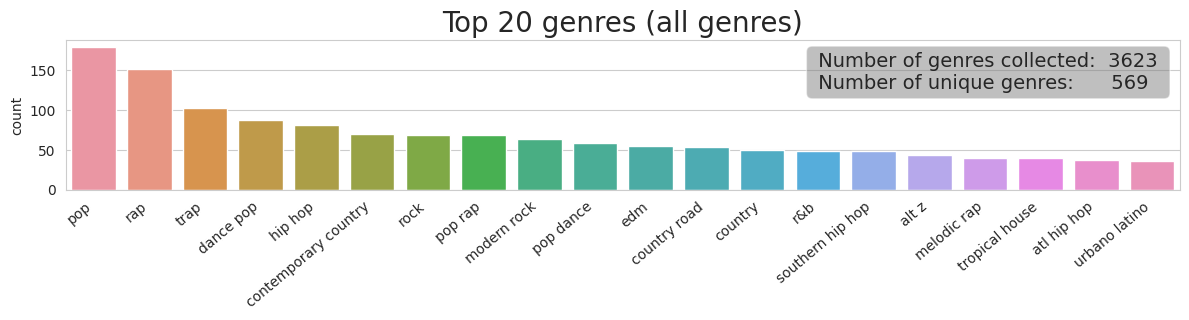

In [73]:
all_genres = make_hist_of_genres(dict_genres, 'all_genres')

On average each artist has around 3 different genres associated with them. The task is now to form exactly one genre per artist, i.e. the top genre. 
From the plot it can be seen that 103 artists have no genre. These will be removed. 
It is also visible that many genres somewhat overlap. For example, "contemporary country" and "country road" can be considered genres under "country". The idea is that we do not differentiate between types under a broader genre. Some might argue that rap is a genre under hip-hop, however, we also try to avoid deleting too many genres. 

By splitting each artist genres into word tokens, we can for example count how many times the word "pop" and "r&b" appears, and then take the most frequent one-word genre - where the genres defined are the ones spotify have defined. This is an example from the artist "The Weeknd":


In [74]:
artist_str, value_str, splitter_str = 'The Weeknd', 'all_genres', ' '
print(f'All genres from The Weeknd:                                                         {dict_genres_copy[artist_str][value_str]}')
print(f'Split by words. Word tokens:                                                        {list(itertools.chain(*[genre.split(splitter_str) for genre in dict_genres_copy[artist_str][value_str]]) )}')
print(f'Count frequent word tokens. Counted Word tokens:                                    {Counter(list(itertools.chain(*[genre.split(splitter_str) for genre in dict_genres_copy[artist_str][value_str]]) )).most_common()}')
print('Check if the most frequent word tokens are in a defined list of genres. Top-genre:  [\'pop\']')


All genres from The Weeknd:                                                         ['canadian contemporary r&b', 'canadian pop', 'pop']
Split by words. Word tokens:                                                        ['canadian', 'contemporary', 'r&b', 'canadian', 'pop', 'pop']
Count frequent word tokens. Counted Word tokens:                                    [('canadian', 2), ('pop', 2), ('contemporary', 1), ('r&b', 1)]
Check if the most frequent word tokens are in a defined list of genres. Top-genre:  ['pop']


Exceptions are which can arise:
* Having multiple word tokens which are genres. Here, we choose randomly. 
* Having a genre, but no word tokens fit with the defined list of genres. Solved by choosing randomly from the list of all genres without splitting into word tokens. 
* Having zero genres. These are removed.

The function/code used to define the top genres can be found here: **LINK LINK LINK**

We load the updated data, not including artist without a genre:

In [75]:
dict_features_updated, dict_genres_updated = read_files(True)

Let's visualize the top 20 most frequent genres again, and see how many genres are left after the preprocessing:

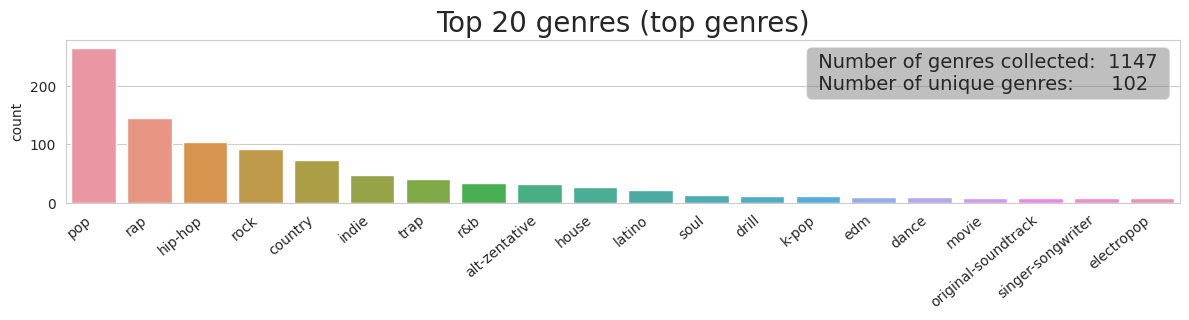

In [76]:
top_genres = make_hist_of_genres(dict_genres, 'top genre')

The number of genres both collected and being unique is reduced, and the top genre is now defined!

### 4. Text 


Now let's preprocess our text. Lyrics from Genius.com are very weirdly formatted, containing lot's of weird symbols, and also a bunch of newline characters. Let's fix that.

In [156]:
df_lyrics = df_lyrics_pre.copy()
#Remove artist with no lyrics. There are exapmles of this in Genius.com. 
df_lyrics['len_lyrics'] = df_lyrics.lyrics.apply(lambda x: len(x))
df_lyrics = df_lyrics[df_lyrics.len_lyrics != 0]

#Join the lists of lyrics into one, and sub out with Regex. Also split on ' Lyrics', because that is where the lyrics begin.
df_lyrics['processed'] = df_lyrics['lyrics'].apply(lambda x : ' '.join(x))
df_lyrics['processed'] = df_lyrics['processed'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x).replace('\n', ' ').split(' Lyrics'))
# We drop these three because they contain errors, and one of them is German. This was causing an issue later on.
df_lyrics = df_lyrics.drop([408, 452, 651])
df_lyrics = df_lyrics.drop_duplicates(subset='artist')
df_lyrics['processed'] = df_lyrics['processed'].apply(lambda x: x[1])

Let's add the artists' genre into the DataFrame.

In [157]:
genres_intermediary = {}
for k, v in dict_genres_updated.items():
    genres_intermediary[k[0]] = v['top genre']

In [158]:
df_lyrics['genre'] = df_lyrics['artist'].apply(lambda x: genres_intermediary[x] if x in genres_intermediary.keys() else None)
df_lyrics = df_lyrics.dropna()
print(df_lyrics.shape)
df_lyrics.head(5)

(971, 5)


artist                                             lyrics   
0   Marc E. Bassy  [33 ContributorsYou & Me Lyrics[Verse 1: Marc ...  \
1     MisterWives  [20 ContributorsReflections Lyrics[Verse 1]\nY...   
2      YBN Nahmir  [185 ContributorsRubbin off the Paint Lyrics[I...   
3   Jeremy Zucker  [41 ContributorsTranslationsEspañol​comethru L...   
4  Jessica Darrow  [110 ContributorsTranslationsTagalog / ᜆᜄᜎᜓᜄ᜔S...   

   len_lyrics                                          processed   
0           3   Girl you party all the time Don't let me stay...  \
1           3   You didn't close the door Left a crack open, ...   
2           3   That's what I thought you said Now let me off...   
3           3   I might lose my mind Waking when the sun's do...   
4           3   I'm the strong one, I'm not nervous I'm as to...   

           genre  
0            rap  
1          indie  
2           trap  
3  alt-zentative  
4          movie

So, with the ones we have genres for, we're down to 982 rows. Now we will tokenize these, removing stopwords - including some we've defined ourselves, such as uh, oh and ah - as these are a big part of song lyrics.
We will also remove any words that contain a dash, as many, many lyrics include different adlibs such as 'ah-ah-ah', which don't contribute anything.

In [176]:
def tokenizer(input_text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    manual_stop_words = set(['uh', 'oh'])
    stop_words = list(stop_words.union(manual_stop_words))
    stop_words = [re.sub('[^a-z_-]', ' ', stop_word) for stop_word in stop_words]
    input_text = input_text.lower()
    input_text = re.sub('[^a-z_-]', ' ', input_text)
    tokens = nltk.tokenize.word_tokenize(input_text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1 and ('-' or ' - ') not in token]

    return tokens
df_lyrics['tokens'] = df_lyrics['processed'].apply(lambda x: tokenizer(x))
output = df_lyrics[['artist', 'tokens', 'genre']].set_index('artist').T
print(df_lyrics.shape)

In [185]:
print(df_lyrics.shape)
output[df_features.T.columns[:10]]

(971, 6)


artist                                        Post Malone   
tokens  [hahahahaha, tank, god, ayy, ayy, fuckin, hoes...  \
genre                                                 rap   

artist                                         Juice WRLD   
tokens  [enviyon, mix, still, see, shadows, room, take...  \
genre                                                 rap   

artist                                       Lil Uzi Vert   
tokens  [alright, alright, quite, alright, money, righ...  \
genre                                                 rap   

artist                                            J. Cole   
tokens  [first, things, first, rest, peace, uncle, phi...  \
genre                                             hip-hop   

artist                                       Travis Scott   
tokens  [astro, yeah, sun, freezin, cold, already, kno...  \
genre                                                 rap   

artist                                         The Weeknd   
tokens  [yeah, yeah, yeah, man, road, doin, promo, sai...  \
genre                                                 pop   

artist                                       XXXTENTACION   
tokens  [yeah, someone, afraid, let, go, decide, ever,...  \
genre                                                 rap   

artist                                           Lil Baby   
tokens  [davinci, yeah, shoutout, whole, oakland, city...  \
genre                                                trap   

artist                                     Kendrick Lamar   
tokens  [nobody, pray, day, way, ayy, remember, syrup,...  \
genre                                                 rap   

artist                                      Glass Animals  
tokens  [road, shimmer, wigglin, vision, heat, heat, w...  
genre                                                 pop

Now we have all the tokenized lyrics for the different artists.

# Tools, theory and analysis. Describe the process of theory to insight


Talk about how you’ve worked with text, including regular expressions, unicode, etc.

Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.

How did you use the tools to understand your dataset?

________________


The natural order of this project is to first look at the methods for the network formed and then the methods for the text.

**Network**

We will be forming an undirected network with the nodes as artists and the edges formed by features, where the weight of the edge is the number of features going both ways (we will use the word "collaborations" through-out the text). First of all, we will be visualizing degree distribution of the network in order to determine how common features are between artist. 

In order to determine if the links between artist can be explained by the top genres (hypothesis: "musicians are most likely to collaborate with artist within their own genre), the modularity measure of the network will be used. This metric measures the how good a partition the genres are. A large modularity would suggest that the genres does describe the collaborations between artists.
This can be compared to random networks using the double edge swap algorithm. The double edge swap algorithm preserves the degrees of the nodes (number of features of an artist). Thus, ensures the same graph structure, therefore making the simulated graphs possible to compare to the original one. It is therefore possible to compare with the original graph based on the question: "What if each artist links/features were random?".
Hence, we are able to determine if the modularity of the genre partition is significantly different from the random edges. 

The optimal partitioning can be found by the Louvain-algorithm. By using this, we can investigate if there exists a better partitioning of the graph. If so, we are able to analyze the louvain-algorithms partitions, and if they seem to suggest inter-genre features. This can be done with a confusion matrix comparing he genre partitioning and the best partitioning.



**Text**

For working with the text, we're using a lot of different tools to properly tokenize it. First and foremost we use Regex to remove out all weird characters and punctuation, that are not letters. We also use a plethora of Pandas functionality to crop the text, such that it is actually the lyrics. Genius.com is great for getting lyrics, but their lyrics are user-supplied, so there tends to be some diversity in how things are spelled, and how punctuation is utilized. A lot of them include things like descriptors for when it is a verse, \[Verse], and a chorus, \[Chorus]. 
Afterwards the initial cleanup we utilize NLTK for their stop-word list. We also utilizer their tokenizer to actuallty do the tokenization.
Once we've obtained the tokens for each artist, and found their top-genre, we can group them based on this genre.

We will focus on 8 popular genres, namely pop, rap, hip-hop, rock, country, indie, trap and R&B.

For each of these genres, we will look at the term frequency(TF) across the genres, afterwards we will look at the inversed document frequency (IDF) and finally we will look at the (TF-IDF) per genre, to see what is unique for each of these genres.

## _Network analysis_

The following section will walk-through the forming of the network and the analysis of it.

### 1. Form the network

First, we define a function to make the described network with the attribute "group" being the top genre. Second, we form the network.

In [51]:
def make_network(dict_features_updated, dict_genres_updated, islimitedartists=True):
    """Function to make graph from dict of features. Edges will be features. The weight is features shared between artists."""
    G = nx.Graph()
    for artist in dict_features_updated.keys():
        artist_name = artist[0]
        artist_id = artist[1]

        if dict_genres_updated[(artist_name,artist_id)]['top genre'] in ['pop', 'rap', 'hip-hop', 'rock', 'country']:
            G.add_node(artist_name, label=artist_id, group={'pop': 'blue', 'rap': 'orange', 'hip-hop': 'green', 'rock': 'red', 'country': 'purple'}[dict_genres_updated[(artist_name,artist_id)]['top genre']])

        else:
            G.add_node(artist_name, label=artist_id, group=dict_genres_updated[(artist_name,artist_id)]['top genre'])
        # exclude nodes removed since no genre
        
        res = Counter(dict_features_updated[artist])
        for key in res.keys():
            if key in dict_features_updated.keys() and islimitedartists:
                if G.has_edge(artist_name, key[0]):
                    G.get_edge_data(artist_name, key[0])['weight'] += res[key]
                else:
                    G.add_edge(artist_name, key[0], weight=res[key])
    return G

In [52]:
G_artist = make_network(dict_features_updated, dict_genres_updated, islimitedartists=True)

### 2. Properties of the network - degrees


We first define a plotting function.

In [42]:
def plot_distribution_of_degrees(G_artist):
    dict_degrees_per_genre = {}
    top5_genres = ['pop', 'rap', 'hip-hop', 'rock', 'country']
    for genre_type in top5_genres:
        dict_degrees_per_genre[genre_type] = np.array([G_artist.degree(x, weight='weight') for x,y in G_artist.nodes(data=True) if y['group']==genre_type])


    list_all_degrees= np.array([v for k,v in G_artist.degree(weight='weight')])


    dict_colors = {'pop': 'blue', 'rap': 'orange', 'hip-hop': 'green', 'rock': 'red', 'country': 'purple'}
    # Make two histograms of the degree distribution with subfigures
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    for genre_type in 'pop', 'rap', 'hip-hop', 'rock', 'country':
        sns.histplot(dict_degrees_per_genre[genre_type]+1,ax=ax2, label=genre_type, stat='percent', element='poly', fill=True, alpha=0.2, log_scale=True)
        ax2.vlines(np.mean(dict_degrees_per_genre[genre_type]), ymin= 0, ymax= 45, linestyles='dashed', label=f'mean: {np.mean(dict_degrees_per_genre[genre_type]):.0f}', colors=dict_colors[genre_type], alpha=0.5)

    ax2.legend()
    ax2.set_title('Degree distribution for each genre')
    sns.histplot(list_all_degrees+1, ax=ax1, label='All artists', stat='percent', element='poly', fill=True, alpha=0.2, log_scale=True, color='mediumturquoise')
    ax1.vlines(np.mean(list_all_degrees), ymin= 0, ymax= 22, linestyles='dashed', label=f'mean: {np.mean(list_all_degrees):.0f}', colors='mediumturquoise', alpha=0.5)

    ax1.set_title('Degree distribution for all artists')
    ax1.legend()

    plt.show()

The distribution of the degrees of the network in percentage are plotted below. The first plot shows the distribution of all artists' degrees. The second histogram shows the distribution of the degrees for each of the top 5 genres' artist.

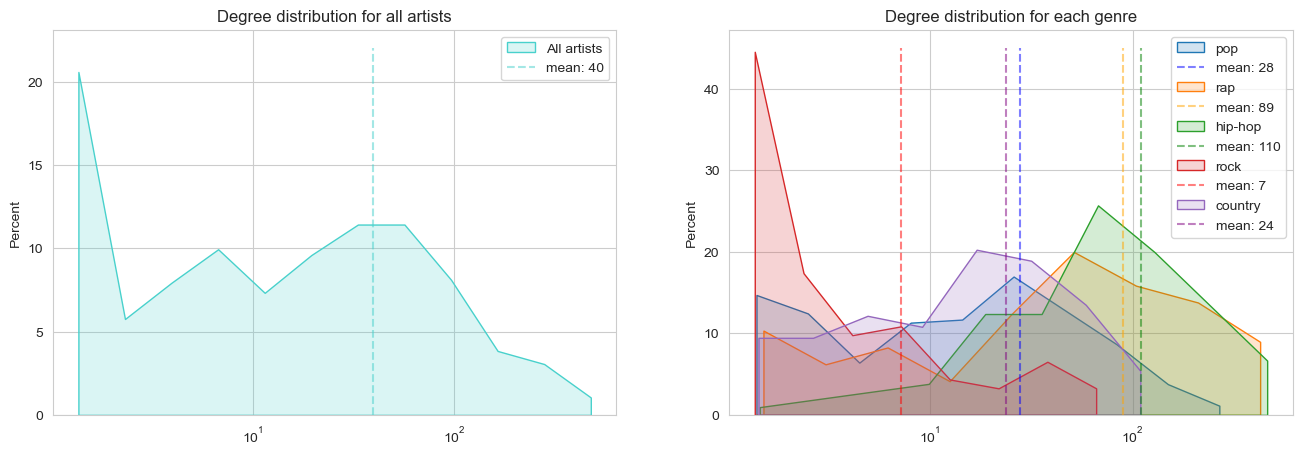

In [43]:
plot_distribution_of_degrees(G_artist)


The first graph shows that the distribution of degrees is right-skewed (note the log-scale). This means that many artist have very few features, however, a small amount of artists have significantly more features. The mean of the degrees is 40. The dis-continuous histogram might suggest that more insights about the structure can be gained by isolating the artists' genres. 

The second graph exactly shows this. The distributions for each of the top 5 genres proves that there exists differences of the degrees for each genre. The artist in the rock genre (red) have significantly less collaborations than in the other four genres with a mean of 7. The distribution is heavily right-skewed. Pop and country has similar distributions and their means of 28 and 24 lie under the all artists' mean. Finally, the two genres rap and hip-hop have means of 89 and 110 and are pulling the overall mean upwards. The distributions are less right-skewed (again remember the log-scale), thus it is more common within these genres to have a higher number of collaborations. While the hip-hop genre has higher mean and relatively less artists with fewer than 10 collaborations, the two distributions are relatively similar. This might be expected, since (at least for us) the genres are hard to stricly differ. 

If we plot the top 15 artists with the most collaborations, it is visible that most of these are artists under the genre "hip-hop" or "rap":

In [44]:
list_names_and_degrees = [(k,v,g[1]) for (k,v),g in zip(G_artist.degree(weight='weight'),G_artist.nodes(data='group'))]
df_top_collaborators = pd.DataFrame(list_names_and_degrees, columns=['artist name', 'number of features', 'genre']).sort_values(by='number of features', ascending=False).T
df_top_collaborators.columns = range(1,len(list_names_and_degrees)+1)
df_top_collaborators.loc[:, :15]

1          2           3           4   \
artist name          Future  Lil Wayne  Young Thug  Gucci Mane   
number of features      603        569         549         501   
genre               hip-hop        rap         rap     hip-hop   

                                5          6         7        8         9   \
artist name         French Montana  Rick Ross  Lil Durk  Juicy J  DJ Drama   
number of features             455        389       371      370       367   
genre                      hip-hop        rap     drill  hip-hop       rap   

                              10          11       12        13  \
artist name         Metro Boomin  Mac Miller    Drake  2 Chainz   
number of features           365         363      355       353   
genre                       trap         rap  hip-hop   hip-hop   

                               14         15  
artist name         Ty Dolla $ign  DJ Khaled  
number of features            348        348  
genre                     hip-hop        rap

### 3. Visualize network

The graph can be visualized with netwulf and the saved image is seen below. The five top genres have the same color as above. Besides that the lime-green color is trap-artists:

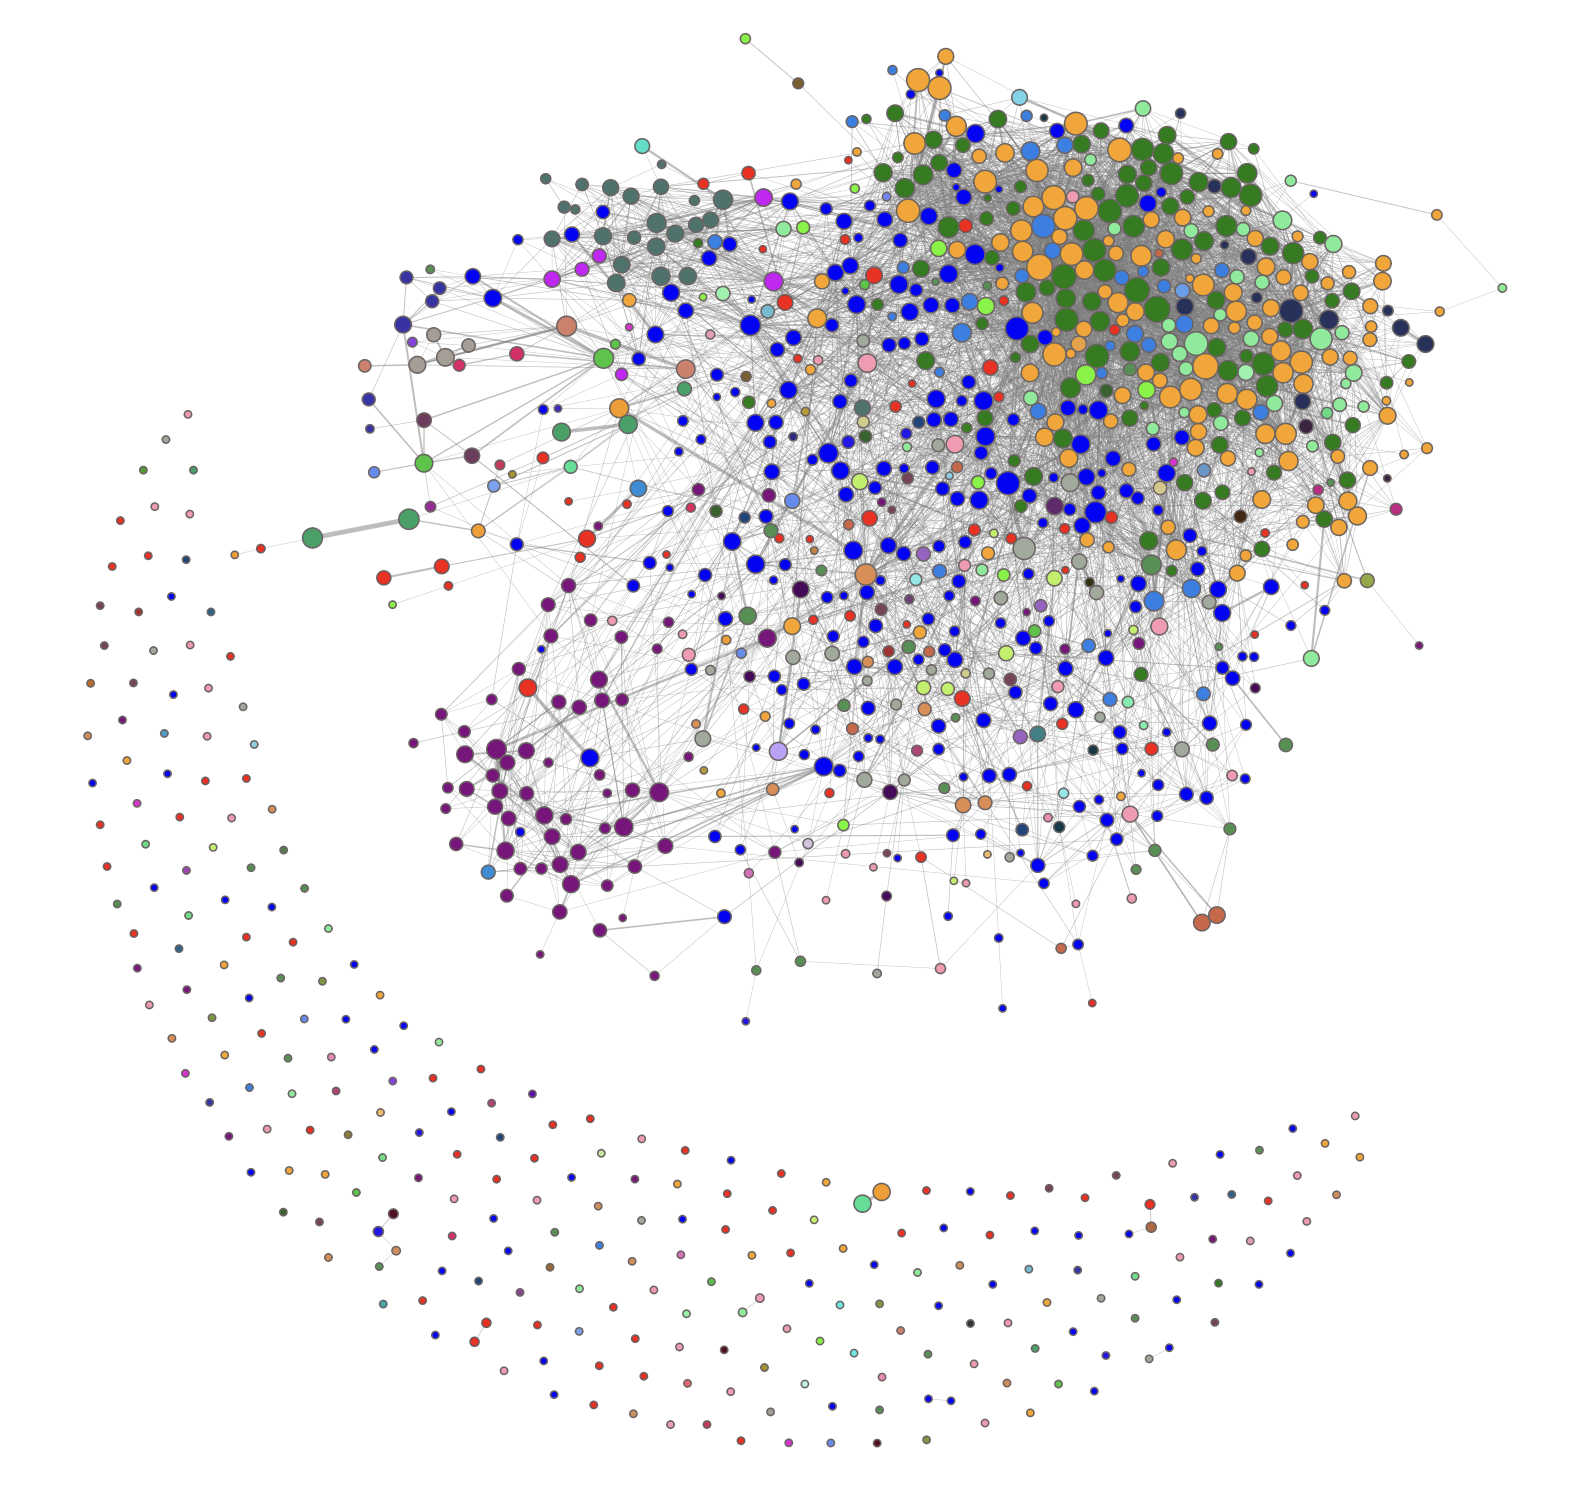

In [54]:
path = 'images/graph.png'
display(Image(filename=path, width=500, height=500))

### 4. Analysis of modularity

We wish to investigate the modularity of the network inorder to access the likelihood of collaborations happening within the genre and inbetween genres.

First, we define a helper-function making the partitions:

In [61]:
def PartitioningGeneral(partion_dict):
    groups_dict = {key: [] for key in set(list(partion_dict.values()))}
    for instance in list(partion_dict.items()):
        groups_dict[instance[1]].append(instance[0])

    return list(groups_dict.values())

We need calculate the modularity of the genre partitioning and use the double edge swap to calculate 1000 modularities for random graphs:


In [63]:
dict_genres_partition = {k[0]: v['top genre'] for k, v in dict_genres_updated.items()}
partition_genres = PartitioningGeneral(dict_genres_partition)
modularity_genre = nx.community.modularity(G_artist, partition_genres)


GGG_copy = G_artist.copy()
list_modu = []
for _ in tqdm(range(1000)):
    G_swapped = nx.double_edge_swap(GGG_copy, nswap=G_artist.number_of_edges()*2, max_tries=1000000, seed=27)
    modu = nx.community.modularity(G_swapped, partition_genres)
    list_modu.append(modu)

It is now possible to visualise the distribution of the modularities for the random graphs and the one for the genre partitioning:

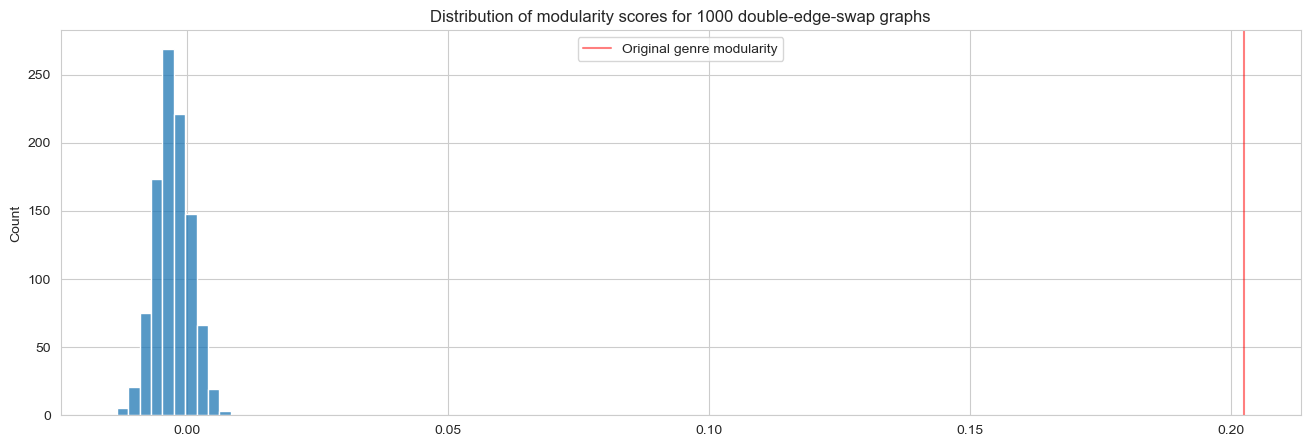

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
sns.histplot(list_modu,bins=10)
plt.axvline(modularity_genre, c='red', label='Original genre modularity', alpha=0.5)
#plt.axvline(modularity_louvain, c='green', label='The Louvain partitions modularity')
plt.title('Distribution of modularity scores for 1000 double-edge-swap graphs')
plt.legend(loc=9)
plt.show()

It is visible from the plot, that the modularity of the genre partitioninng on the graph is significantly different from the random graphs' modularities. Hence, the genres does somewhat form meaningful groups in the network in terms of the connections being collaborations. However, it is reasonable to investigate if a better partitioning exists. This will be done in the following section.

### 5. Community detection

We use the Louvain algorithm to find the best partition of the graph.

In [64]:
dict_louvain_partition = community_louvain.best_partition(G_artist)
partition_louvain = PartitioningGeneral(dict_louvain_partition)
modularity_louvain = nx.community.modularity(G_artist, partition_louvain)
print('',f'Genre   ---   modularity: {modularity_genre:.2f}', '   number of groups:', len(partition_genres), \
       '\n', f'Louvain ---   modularity: {modularity_louvain:.2f}', '   number of groups:', len(partition_louvain)) 


 Genre   ---   modularity: 0.20    number of groups: 101 
 Louvain ---   modularity: 0.56    number of groups: 262


The Louvain modularity is significantly higher, meaning that better partitions exist. It can be seen by the number of groups of the Louvain partitions, that more communities exist within the graph. We can compare these partitions in the next section.

### 6. Comparing partition

A confusion matrix of the largest eight communities from the genre and best partition can help us determine the differences and similarities between the two.

We define two helper functions to make the plot:

In [65]:
def GetMatrix(communities1, communities2):
    fulllist = []
    for l1 in communities2:
        appendlist = []
        for l2 in communities1:
            appendlist.append(len(list(set(l1) & set(l2))))
        fulllist.append(appendlist)
    np.array(fulllist)
    return np.array(fulllist)

def PartitioningGeneral_adj(partion_dict):
    groups_dict = {key: [] for key in set(list(partion_dict.values()))}
    for instance in list(partion_dict.items()):
        groups_dict[instance[1]].append(instance[0])

    return groups_dict

Now we form the confusion matrix of the eight largest communities - the x-axis are the genres and y-axis are the louvain genres:


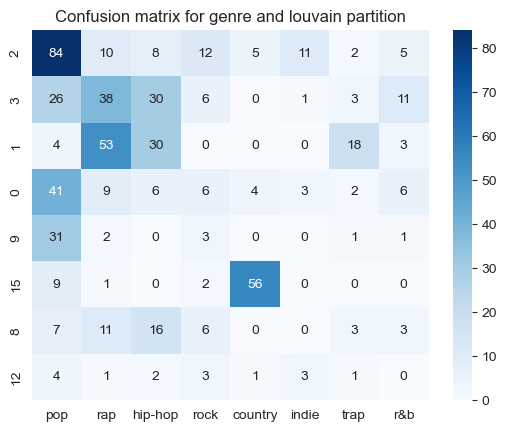

In [40]:
# make matrix
M = GetMatrix(partition_genres,partition_louvain)
# Get top 5 genres
largest_genres_idx = M.sum(axis=0).argsort()[-8:][::-1]
largest_genre_names = [list(PartitioningGeneral_adj(dict_genres_partition).keys())[i] for i in largest_genres_idx]
# Get top 5 louvain partitions
largest_louvain_idx = M.sum(axis=1).argsort()[-8:][::-1]
largest_louvain_names = [list(PartitioningGeneral_adj(dict_louvain_partition).keys())[i] for i in largest_louvain_idx]

sns.heatmap(M[largest_louvain_idx,:][:,largest_genres_idx], annot=True, cmap='Blues',xticklabels=largest_genre_names, yticklabels=largest_louvain_names)
plt.title('Confusion matrix for genre and louvain partition')
plt.show()

It should be noted that the matrix only contains a smaller part of the 101x262 matrix. However, multiple things can be analysed from the plot. 

Best partition group 0, 2 and 9 mostly consists of artists from the pop genre. This is a sign that groups exists within this genre, hence, some groups of pop artists are more likely to collaborate. 

Group 3 is notable since it consists of a large group of pop artists from the pop, rap and hip-hop genre. Else, there is a tedency that rap and hip-hop artists are more likely to collaborate. Group 1 suggests that trap is somewhat included in this community. 
This makes sense since the genres are closely related, and when defining the top genre of artists it was common to find a draw between rap and hip-hop (making it a random decision).

Not a lot of rock artists are included in the 8 largest groups and there is no clear sign which other genres rock artist collaborate with, maybe pop. Country artists has one large group 15 suggesting that they are likely to feature on songs within their own genre. 


These are some of the most visible conclusion to be made from the confusion matrix. 

### 7. Louvain-partition's network visualized

The Louvain partition's network can be visuallized as well to get a broader view over the differences in the communities. The two network are plotted beside each other:

In [68]:
# Make a similar graph but with the group of the nodes being the louvain partition
G_artist_louvain = G_artist.copy()
for node in G_artist_louvain.nodes():
    G_artist_louvain.nodes[node]['group'] = dict_louvain_partition[node]


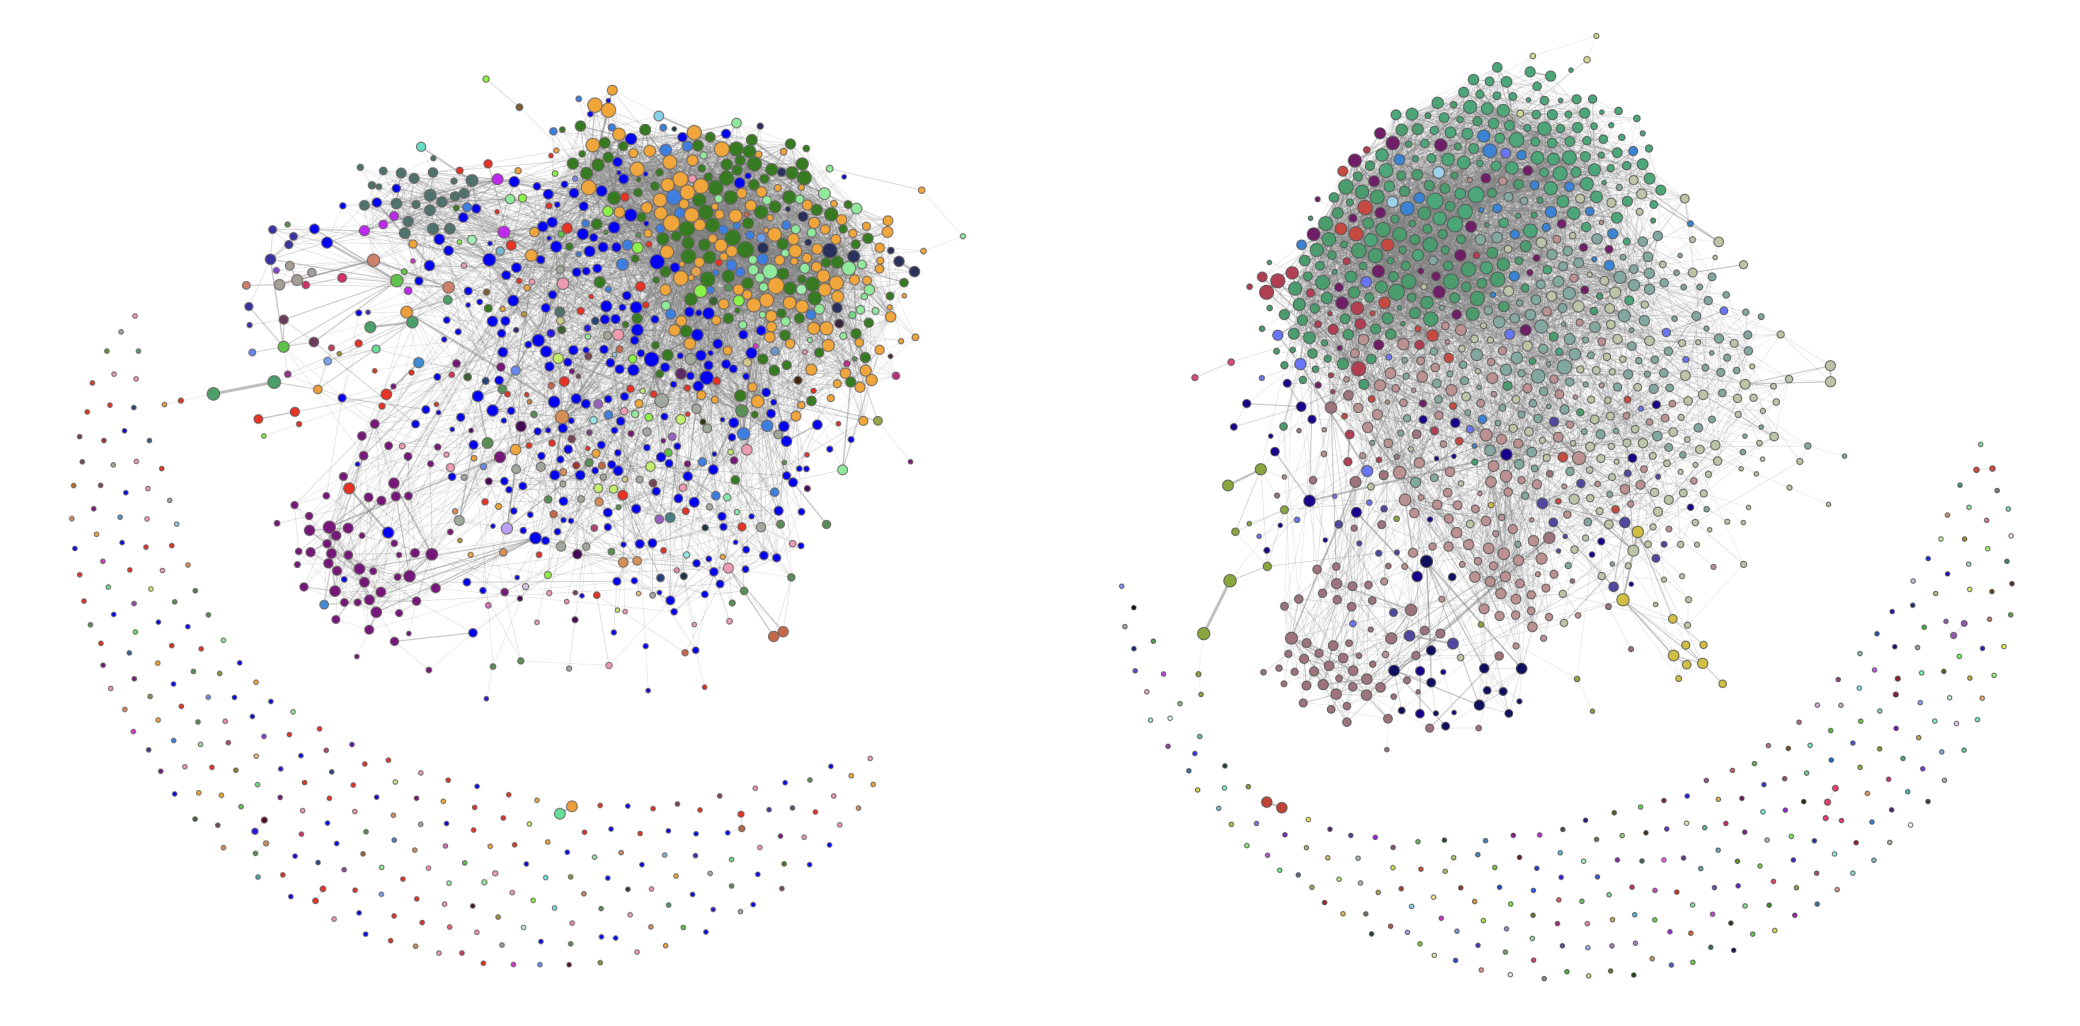

In [70]:
path = 'images/graph_both.png'
display(Image(filename=path, width=800, height=800))

The most profound difference is the amount of rap and hip-hop artists which is primarily forming one large group in the network, proving our analysis of from the confusion matrix right. Else, it is generally visiable that the partitions to the right are better at describing the collaborations. 

## _Text_

In [187]:
df_lyrics.head()

artist                                             lyrics   
0   Marc E. Bassy  [33 ContributorsYou & Me Lyrics[Verse 1: Marc ...  \
1     MisterWives  [20 ContributorsReflections Lyrics[Verse 1]\nY...   
2      YBN Nahmir  [185 ContributorsRubbin off the Paint Lyrics[I...   
3   Jeremy Zucker  [41 ContributorsTranslationsEspañol​comethru L...   
4  Jessica Darrow  [110 ContributorsTranslationsTagalog / ᜆᜄᜎᜓᜄ᜔S...   

   len_lyrics                                          processed   
0           3   Girl you party all the time Don't let me stay...  \
1           3   You didn't close the door Left a crack open, ...   
2           3   That's what I thought you said Now let me off...   
3           3   I might lose my mind Waking when the sun's do...   
4           3   I'm the strong one, I'm not nervous I'm as to...   

           genre                                             tokens  
0            rap  [girl, party, time, let, stay, mind, adderall,...  
1          indie  [close, door, left, crack, open, ignore, faint...  
2           trap  [thought, said, let, offer, rebuttal, ayy, ayy...  
3  alt-zentative  [might, lose, mind, waking, sun, riding, highs...  
4          movie  [strong, one, nervous, tough, crust, earth, mo...

In [196]:
tokens_genres = df_lyrics.groupby('genre').apply(lambda x: x['tokens'].sum())
top8_genres = ['pop', 'rap', 'hip-hop', 'rock', 'country', 'indie', 'trap', 'r&b']

top8_tokens = tokens_genres[top8_genres]

top8_tokens_dict = {k:v for k,v in top8_tokens.items()}

for k in top8_tokens_dict.keys():
    print(f'Genre {k} has {len(top8_tokens_dict[k])} tokens')

Genre pop has 41513 tokens
Genre rap has 34676 tokens
Genre hip-hop has 29196 tokens
Genre rock has 10342 tokens
Genre country has 11621 tokens
Genre indie has 5255 tokens
Genre trap has 9601 tokens
Genre r&b has 5931 tokens


Here we have the total number of tokens in each genre. Let's define our functions:

In [197]:
def TermFrequency(tokens):
    tf_dict = {}
    for token in tokens:
        if token in tf_dict:
            tf_dict[token] += 1
        else:
            tf_dict[token] = 1
    return tf_dict

def idf(tf_dict):
    idf_dict = {}
    N = len(tf_dict)
    all_tokens = set([token for tokens in tf_dict.values() for token in tokens])

    for token in all_tokens:
        n = 0
        for tokens in tf_dict.values():
            if token in tokens:
                n += 1
        idf_dict[token] = np.log(N / n)

    return idf_dict

def tf_idf(tf_dict, idf_dict):
    tf_idf_dict = {}

    for community, tokens in tf_dict.items():
        tf_idf_dict[community] = {}
        for token in tokens:
            tf_idf_dict[community][token] = tokens[token] * idf_dict[token]

    return tf_idf_dict

And we can now get the top 5 words for each genre:

In [199]:
genres_tf = {}
for genre in top8_tokens_dict.keys():
    genres_tf[genre] = TermFrequency(top8_tokens_dict[genre])
    sort5 = sorted(genres_tf[genre].items(), reverse=True, key=lambda x: x[1])
    print(f'Genre {genre} has top 5 words: {sort5[:5]}')

Genre pop has top 5 words: [('like', 949), ('love', 765), ('know', 622), ('na', 599), ('got', 546)]
Genre rap has top 5 words: [('like', 769), ('got', 634), ('yeah', 523), ('know', 475), ('nigga', 403)]
Genre hip-hop has top 5 words: [('like', 719), ('got', 434), ('yeah', 375), ('get', 352), ('nigga', 289)]
Genre rock has top 5 words: [('like', 194), ('go', 123), ('know', 99), ('back', 92), ('never', 88)]
Genre country has top 5 words: [('na', 238), ('like', 224), ('know', 165), ('love', 139), ('girl', 131)]
Genre indie has top 5 words: [('low', 175), ('like', 137), ('got', 68), ('know', 62), ('night', 46)]
Genre trap has top 5 words: [('like', 267), ('got', 188), ('nigga', 174), ('bitch', 169), ('yeah', 124)]
Genre r&b has top 5 words: [('got', 130), ('like', 122), ('yeah', 103), ('love', 87), ('know', 85)]


In [201]:
genres_idf = idf(top8_tokens_dict)
print(sorted(genres_idf.items(), reverse=True, key=lambda x: x[1])[:10])

[('bleep', 2.0794415416798357), ('thread', 2.0794415416798357), ('planetary', 2.0794415416798357), ('rememberin', 2.0794415416798357), ('wallets', 2.0794415416798357), ('backstabbed', 2.0794415416798357), ('races', 2.0794415416798357), ('disaffected', 2.0794415416798357), ('shotty', 2.0794415416798357), ('trono', 2.0794415416798357)]


In [202]:
genres_tf_idf = tf_idf(genres_tf, genres_idf)
for genres in genres_tf_idf.keys():
    sort5 = sorted(genres_tf_idf[genres].items(), reverse=True, key=lambda x: x[1])
    print(f'Genre {genres} has top 5 TF-IDF words: {sort5[:5]}')

Genre pop has top 5 TF-IDF words: [('que', 97.10209604816089), ('ti', 87.3365447505531), ('quiero', 81.79136730607354), ('ena', 79.01877858383376), ('tu', 67.92842369487464)]
Genre rap has top 5 TF-IDF words: [('nigga', 189.41146258603146), ('niggas', 86.87998588043781), ('dunno', 66.54212933375474), ('forward', 57.86892592769185), ('ayy', 45.166085374929594)]
Genre hip-hop has top 5 TF-IDF words: [('nigga', 135.8310488520176), ('pedal', 70.70101241711441), ('niggas', 59.55018899751863), ('raf', 49.906597000316054), ('isis', 41.58883083359672)]
Genre rock has top 5 TF-IDF words: [('believer', 37.42994775023704), ('californication', 35.350506208557206), ('sha', 33.27106466687737), ('sail', 29.112181583517703), ('trojan', 29.1121815835177)]
Genre country has top 5 TF-IDF words: [('withdrawals', 29.1121815835177), ('misunderstood', 27.725887222397812), ('cheats', 24.953298500158027), ('tacoma', 22.873856958478193), ('whiskey', 21.487562597358306)]
Genre indie has top 5 TF-IDF words: [('du

And we can now generate wordclouds for each genre:

In [209]:
wordclouds = {}

In [211]:
for genre in genres_tf_idf.keys():
    wordcloud = WordCloud(background_color="white", max_words=100, width=800, height=500).generate_from_frequencies(genres_tf_idf[genre])
    wordclouds[genre] = wordcloud

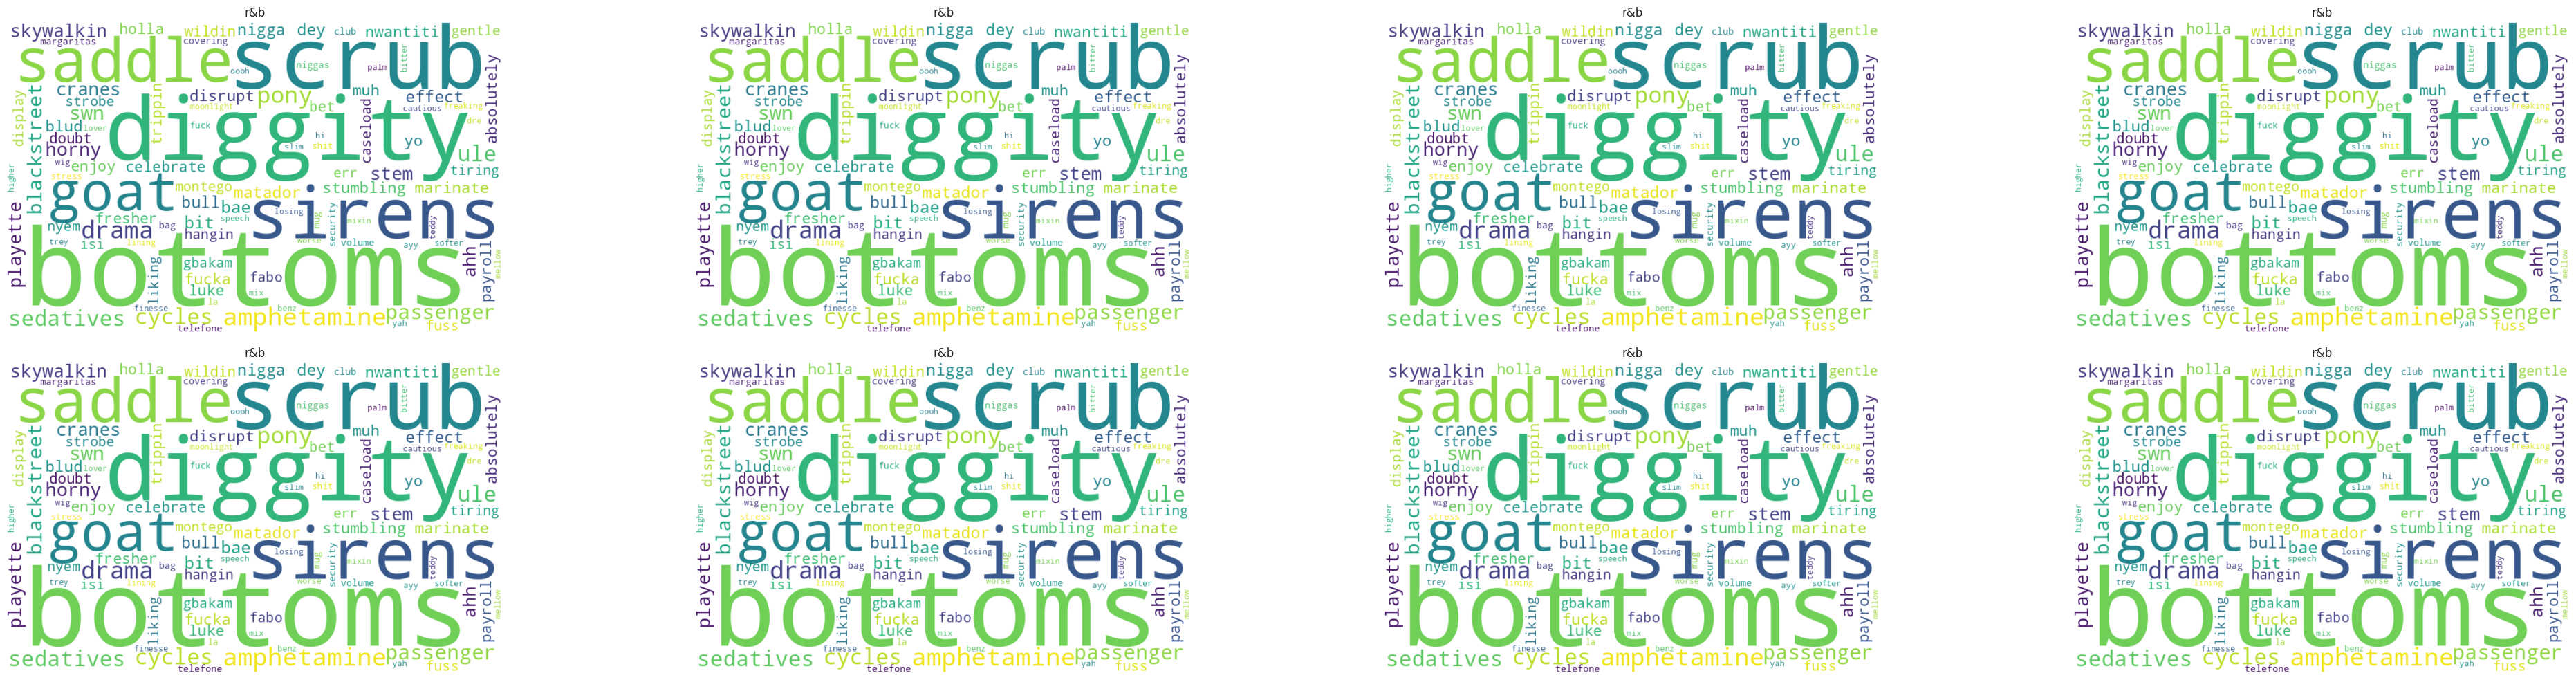

In [224]:
fig, ax = plt.subplots(2, 4, figsize=(40,10))
fig.tight_layout()
ax = ax.flatten()
for axis in ax:
    for genre in wordclouds.keys():
        axis.imshow(wordclouds[genre].to_array(), interpolation="bilinear")
        axis.axis("off")
        axis.title.set_text(genre)

# Discussion. Think critically about your creation



What went well?

What is still missing? What could be improved? Why?

_________


Regarding improvements of the project, some assumptions are made. The analysis is made on artists topping the charts for a long time. We somewhat assume this group to represent their genre well, to make conclusions on these. This assumption can be discussed, and it is likely that a larger number of artists would improve our analysis, since a larger sample size makes the sample closer to the population of data points - however, most of our analysis involves the top 5-8 genres with relatively many data points. We were surprised by the different types of artists and genres included in the 1250 artists having at least one major song. All this considered, we conluded that the sample of 1250 artists were fair to work with. 

We could have hoped for more precise definitions of genres. Our definitions of top-genre was based of a lot of random decisions between hip-hop and rap for example. However, artists are often hard to put into one specific genre, so it might just be the terms of the task. 


OUR WRITTING